Notes:
- West tower common area ventilation shut off from 2024-08-19, 9am, turned on 2024-08-21, 9am - 12pm, and then turned back off

In [8]:
import datetime
import pandas as pd
import statsmodels.formula.api as sm
from functools import reduce
from typing import NamedTuple, Sequence

In [73]:
Note = NamedTuple("Note", [("x", datetime.datetime), ("y", float), ("s", str)])

def display_correlation(df: pd.DataFrame, tgt: str, src: str):
    regression = sm.ols(formula=f"{tgt} ~ {src} -0", data=df).fit()
    print(regression.params)
    [intercept, coefficient] = regression.params.values
    max_src = df[src].max()
    max_pred_tgt = max_src * coefficient + intercept
    ax = df.plot.scatter(tgt, src)
    ax.plot([intercept, max_pred_tgt], [0, max_src], color="0.9", linestyle="dotted")
    ax.text(x=2, y=0.5, s=f"{tgt} = {intercept:.4f} + {src} × {coefficient:.4f} (r²={regression.rsquared:.4f})")
    ax.set_xlim(left=0.25)

def display_data_overview(
    df: pd.DataFrame, notes: Sequence[Note], start_incl: datetime.datetime, end_excl: datetime.datetime
):
    times = [start_incl + datetime.timedelta(hours=h) for h in range(int((end_excl - start_incl).total_seconds() / 60 / 60))]
    df_within_time = df.reset_index(level=0, drop=True).loc[times, :]
    df_grouped = df_within_time.groupby(["Floor", "Location"])
    dfs = [grp[["PM2.5(ug/m³)"]].rename(columns={"PM2.5(ug/m³)": f"L{floor}_{location.replace(" ", "_")}"}) for (floor, location), grp in df_grouped]
    pm25_df = reduce(lambda l, r: l.join(r), dfs)
    
    display(pm25_df)
    ax = pm25_df.resample("5min").interpolate(method="akima").plot(ylabel="PM₂.₅ (µg/m³)")
    # ax = pm25_df.plot(ylabel="PM₂.₅ (µg/m³)")
    for note in notes:
        ax.text(*note)

In [74]:
%run "Common.ipynb"

Time                                   Floor  \
                             min                       max count nunique   
Device                                                                     
01     2024-08-18 17:00:00+08:00 2024-08-21 15:00:00+08:00    64       1   
02     2024-08-18 17:00:00+08:00 2024-08-21 15:00:00+08:00    65       1   
03     2024-08-17 20:00:00+08:00 2024-08-21 15:00:00+08:00    82       1   

       Location  
        nunique  
Device           
01            2  
02            3  
03            3

,L2_Patio,L2_Unit_210,L2_West_Hallway
Time,,,
2024-08-21 04:00:00+08:00,6.8,7.5,5.2
2024-08-21 05:00:00+08:00,7.8,6.8,4.5
2024-08-21 06:00:00+08:00,9.3,6.8,4.4
2024-08-21 07:00:00+08:00,10.1,6.6,4.0
2024-08-21 08:00:00+08:00,20.5,6.9,4.0
2024-08-21 09:00:00+08:00,21.4,8.1,13.6
2024-08-21 10:00:00+08:00,25.6,11.1,21.1
2024-08-21 11:00:00+08:00,27.3,11.9,30.2
2024-08-21 12:00:00+08:00,26.7,11.7,24.8


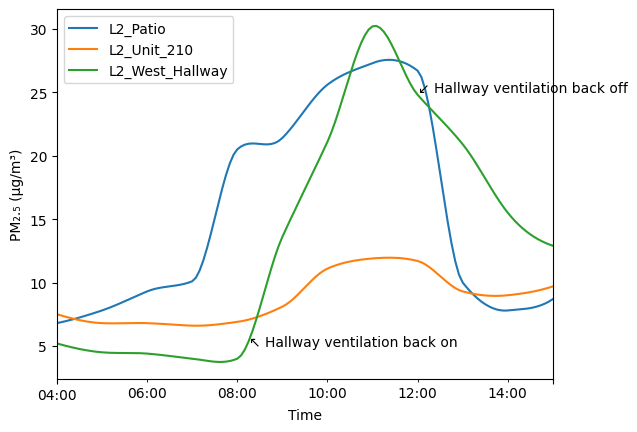

In [75]:
start_incl = datetime.datetime.fromisoformat("2024-08-21T04:00:00+08.00")
end_excl = datetime.datetime.fromisoformat("2024-08-21T16:00:00+08.00")
notes = [
    Note(x=datetime.datetime.fromisoformat("2024-08-21T08:15:00+08.00"), y=5, s="↖ Hallway ventilation back on"),
    Note(x=datetime.datetime.fromisoformat("2024-08-21T12:00:00+08.00"), y=25, s="↙ Hallway ventilation back off"),
]
display_data_overview(df, notes, start_incl, end_excl)